## Sources
https://jovian.ai/sanketec87/gender-classification-pytorch-cnn-project

## Importation des librairies

In [1]:
import os
import pandas as pd
import numpy as np

## Récupération des données

In [2]:
path = "./UTKFace"

In [3]:
df = pd.DataFrame(columns=['age', 'gender', 'ethnicity', 'image'])
for i in os.listdir(path):
    split = i.split("_")
    df2 = pd.DataFrame(data=np.array([[split[0]], [split[1]], [split[2]], [i]]).T, columns=['age', 'gender', 'ethnicity', 'image'])
    df = pd.concat([df, df2])

In [4]:
df[['age', 'gender', 'ethnicity']] = df[['age', 'gender', 'ethnicity']].apply(pd.to_numeric)

In [5]:
df.dtypes

age           int64
gender        int64
ethnicity     int64
image        object
dtype: object

## Analyse des données

In [6]:
ethnicity = {
    0: 'white', 
    1: 'black', 
    2: 'asian', 
    3: 'indian', 
    4: 'others'
}

ethnicity2 = {
    0: 'white', 
    1: 'not white', 
}

gender = {
    0: 'male',
    1: 'female'
}

In [7]:
df.head()

,age,gender,ethnicity,image
0,100,0,0,100_0_0_20170112213500903.jpg.chip.jpg
0,100,0,0,100_0_0_20170112215240346.jpg.chip.jpg
0,100,1,0,100_1_0_20170110183726390.jpg.chip.jpg
0,100,1,0,100_1_0_20170112213001988.jpg.chip.jpg
0,100,1,0,100_1_0_20170112213303693.jpg.chip.jpg


In [8]:
df.shape

(23708, 4)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>],
       [<AxesSubplot:title={'center':'ethnicity'}>, <AxesSubplot:>]],
      dtype=object)

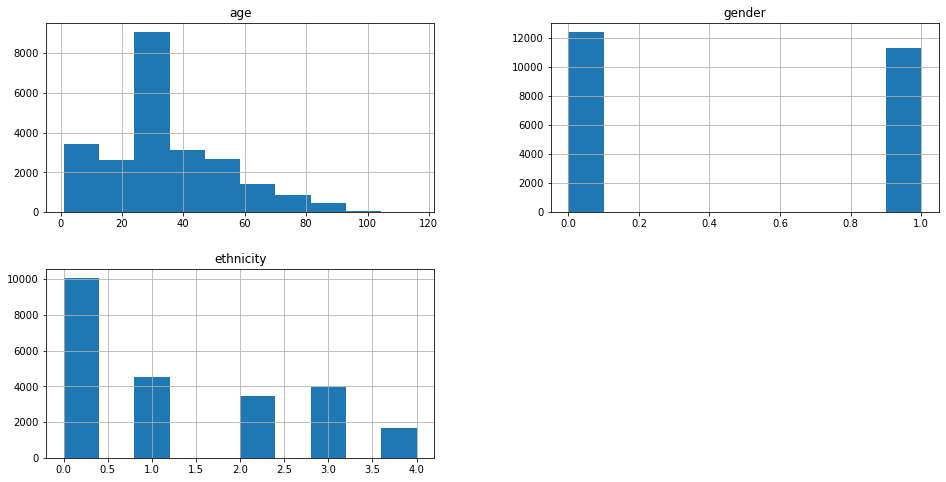

In [9]:
df[['age', 'gender', 'ethnicity']].hist(figsize=(16,8))

## Transformation des données

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')
device = get_device()

In [12]:
class UTKFace(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        #img = torchvision.transforms.functional.to_tensor(Image.open(path + '/' + row['image']))
        #torchvision.transforms.functional.adjust_brightness(img, 1.3)
        return (
            torchvision.transforms.functional.to_tensor(Image.open(path + '/' + row['image'])),
            torch.tensor(row['gender']),
        )

In [13]:
data = UTKFace(df)

In [14]:
train_set, valid_set = torch.utils.data.random_split(data, [13708, 10000])
test_set, valid_set = torch.utils.data.random_split(valid_set, [5000, 5000])
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, pin_memory = True)
valid_loader = DataLoader(valid_set, batch_size=50, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_set, batch_size=250, shuffle=True, pin_memory = True)

### Data Augmentation

https://pytorch.org/vision/master/transforms.html

## Conception du réseau de neurones

In [15]:
import torch.nn as nn
import torch.nn.functional as func

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(32*22*22, 5000)
        self.lin2 = nn.Linear(5000, 100)
        self.lin3 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = self.flat(x)
        x = func.relu(self.lin1(x))
        x = func.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [17]:
loss = nn.CrossEntropyLoss()
model = CNN().to(device)

In [18]:
def train_loop(model, f_loss, dataloader, optimizer):
    err_train = 0
    train_acc = 0
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        pred = model(X)
        loss = f_loss(pred, y)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        err_train += loss.item()
        train_acc += torch.sum(y == pred.argmax(dim=1)).float()
        
    err_train /= len(dataloader)
    train_acc /= float(len(dataloader.sampler))
    return err_train, train_acc.item()

In [19]:
def val_loop(model, f_loss, dataloader):
    err_val = 0
    val_acc = 0
    
    with torch.no_grad():
        model.eval()
        for X, y in dataloader:
            X, y = X.cuda(), y.cuda()
            pred = model(X)
            err_val += f_loss(pred, y).item() 
            val_acc += torch.sum(y == pred.argmax(dim=1)).float()
            torch.cuda.empty_cache()
            
    err_val /= len(dataloader)
    val_acc /= float(len(dataloader.sampler))
    return err_val, val_acc.item()

In [20]:
def test_loop(model, f_loss, dataloader):
    err_test = 0
    test_acc = 0

    for X, y in dataloader:
        X, y = X.cuda(), y.cuda()
        pred = model(X)
        err_test += f_loss(pred, y).item() 
        test_acc += torch.sum(y == pred.argmax(dim=1)).float()
        torch.cuda.empty_cache()
    
    err_test /= len(dataloader)
    test_acc /= float(len(dataloader.sampler))
    return err_test, test_acc.item()

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def model_loop(model, f_loss, train_loader, test_loader, optimizer, epochs=10):
    err_train_list = []
    err_val_list = []
    acc_train_list = []
    acc_val_list = []
    
    for e in range(1, epochs+1):
        print("----------- Epoch {} -----------".format(e))
        err_train, train_acc = train_loop(model, f_loss, train_loader, optimizer)
        err_val, val_acc = val_loop(model, f_loss, test_loader)
        
        err_train_list.append(err_train)
        err_val_list.append(err_val)
        acc_train_list.append(train_acc)
        acc_val_list.append(val_acc)
        
        print("ErrTrain: {: .3f} | AccTrain: {: .3f} | ErrVAL: {: .3f} | AccVAL: {: .3f}".format(err_train, train_acc, err_val, val_acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle('Model Loop')
    
    ax1.plot(range(1, epochs+1), err_train_list, c='r', label='Erreur Train')
    ax1.plot(range(1, epochs+1), acc_train_list, c='g', label='Accuracy Train')
    ax1.legend()
    
    ax2.plot(range(1, epochs+1), err_val_list, c='r', label='Erreur Validation')
    ax2.plot(range(1, epochs+1), acc_val_list, c='g', label='Accuracy Validation')
    ax2.legend()
    
    return model

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model_sgd = model_loop(model, loss, train_loader, valid_loader, optimizer, epochs=10)

----------- Epoch 1 -----------
ErrTrain:  0.694 | AccTrain:  0.478 | ErrVAL:  0.693 | AccVAL:  0.470
----------- Epoch 2 -----------
ErrTrain:  0.693 | AccTrain:  0.506 | ErrVAL:  0.692 | AccVAL:  0.601
----------- Epoch 3 -----------
ErrTrain:  0.691 | AccTrain:  0.627 | ErrVAL:  0.691 | AccVAL:  0.631
----------- Epoch 4 -----------
ErrTrain:  0.690 | AccTrain:  0.600 | ErrVAL:  0.689 | AccVAL:  0.607
----------- Epoch 5 -----------
ErrTrain:  0.689 | AccTrain:  0.590 | ErrVAL:  0.688 | AccVAL:  0.596
----------- Epoch 6 -----------
ErrTrain:  0.687 | AccTrain:  0.595 | ErrVAL:  0.686 | AccVAL:  0.625
----------- Epoch 7 -----------
ErrTrain:  0.685 | AccTrain:  0.615 | ErrVAL:  0.683 | AccVAL:  0.661
----------- Epoch 8 -----------
ErrTrain:  0.682 | AccTrain:  0.652 | ErrVAL:  0.678 | AccVAL:  0.668
----------- Epoch 9 -----------


In [ ]:
model = model_sgd

In [ ]:
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

#model.apply(weight_reset)

In [ ]:
"""
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model_adam = model_loop(model, loss, train_loader, valid_loader, optimizer, epochs=10)
model = model_adam
"""

https://www.google.com/search?q=plt.plot+3+axis&rlz=1C1VDKB_frFR976FR976&sxsrf=APq-WBvV9JM_KJZyR0Y4729snW-Fn7OHUg%3A1647034652063&ei=HMErYrPBA47G4-EPv7KSkAw&oq=plt.plot+3+a&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCCEQoAEyBQghEKABMgUIIRCgAToHCCMQsAMQJzoICAAQgAQQsAM6BAgjECc6CggAEIAEEIcCEBQ6BQgAEIAEOgYIABAWEB5KBAhBGAFKBAhGGABQ8QhYpw1g-xdoAXAAeACAAVWIAYsCkgEBNJgBAKABAcgBCsABAQ&sclient=gws-wiz

In [ ]:
test_loop(model, loss, test_loader)

https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/18

http://man.hubwiz.com/docset/PyTorch.docset/Contents/Resources/Documents/data.html?highlight=sampler#torch.utils.data.Sampler

https://medium.com/mlearning-ai/cnns-with-pytorch-6cf7ed114af7

## Test avec des images du dataset

In [ ]:
img_test, label_test = test_set.__getitem__(0)

In [ ]:
plt.imshow(img_test.permute(1, 2, 0))

In [ ]:
img_test = img_test.reshape(1, 3, 200, 200)

In [ ]:
img_test.shape

In [ ]:
model(img_test.cuda())

In [ ]:
label_test

In [ ]:
img_train, label_train = train_set.__getitem__(0)

In [ ]:
plt.imshow(img_train.permute(1, 2, 0))

In [ ]:
img_train = img_train.reshape(1, 3, 200, 200)

In [ ]:
img_train.shape

In [ ]:
model(img_train.cuda())

In [ ]:
label_train

In [ ]:
torch.cuda.empty_cache()

## Test avec une image inconnue

In [ ]:
img = torchvision.transforms.functional.to_tensor(Image.open('siphano.jpg'))

In [ ]:
plt.imshow(img.permute(1, 2, 0))

In [ ]:
img.shape

In [ ]:
img

In [ ]:
img = img.reshape(1, 3, 200, 200)

In [ ]:
img.shape

In [ ]:
model(img.cuda())

## Test avec une webcam

In [ ]:
!pip install opencv-python tensorflow
!pip install cvlib
!pip install --upgrade cvlib

In [ ]:
import os
import cvlib as cv
import cv2

In [ ]:
webcam = cv2.VideoCapture(0)
while webcam.isOpened():
    status, frame = webcam.read()
    face, confidence = cv.detect_face(frame)
    
    for ind, f in enumerate(face):
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        
        cv2.rectangle(frame, (startX, startY), (endX, endY), (0,255,0), 2)
        
        face_crop = np.copy(frame[startY:endY, startX:endX])
        
        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue
            
        face_crop = cv2.resize(face_crop, (200, 200))
        img = torchvision.transforms.functional.to_tensor(Image.fromarray(face_crop))
        img = img.reshape(1, 3, 200, 200)
        
        pred = model(img.cuda()).argmax(dim=1).item()
        
        label = ethnicity[pred]

        label = "Ethnicity: {}".format(label)
        
        Y = startY - 10 if startY - 10 > 10 else startY + 10
        
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
    cv2.imshow("ethnicity detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

webcam.release()
cv2.destroyAllWindows() 